In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport src.utils.training_funcs
%aimport src.models.vae
%aimport src.models.encoder
%aimport src.models.decoder

In [3]:
import torch
import torch.optim as optim

import pandas as pd
from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
from torchvision import transforms
from torchinfo import summary

from src.datasets.irma_dataset import IrmaDataset
from src.utils.transforms import MinMaxScaler
from src.models.vae import VAE
from src.utils.train_val_split import train_val_split
from src.utils.training_funcs import train, validate, kl_reconstruction_loss, get_metrics_str

In [4]:
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def plot_reconstructions(model, data, n=4):

    fig, axs = plt.subplots(2, n)
    inv_normalize = transforms.Normalize((-1,), (2,))

    with torch.no_grad():
        for i, data in enumerate(data, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)

            for ax, reconstructed, original in zip(range(n), outputs[0], inputs):
                reconstructed = inv_normalize(reconstructed)      # unnormalize
                original = inv_normalize(original)                # unnormalize
                # original = original / 2 + 0.5     # unnormalize
                # print(reconstructed[0])
                # print(original[0])

                axs[0][ax].imshow(reconstructed[0].cpu(), cmap='gray')
                # axs[0][ax].imshow(reconstructed.cpu().permute(1,2,0))
                axs[1][ax].imshow(original[0].cpu(), cmap='gray')
                # axs[1][ax].imshow(original.cpu().permute(1,2,0))
                axs[0][ax].axis('off')
                axs[1][ax].axis('off')
            plt.show()

            break

In [5]:
import numpy as np

def get_latent(model, data, label_mapper=lambda l: l):

    latent_features = (np.ndarray((0, model.latent_dim)), np.ndarray(0))

    with torch.no_grad():
        data_len = 0
        for i, data in enumerate(data, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data[0].to(device)
            data_len += len(data[0])
            labels = data[1]

            outputs = model.encoder(inputs)
            latent = outputs[0]

            latent_features = (
                np.concatenate((latent_features[0], latent.cpu().detach().numpy())),
                np.concatenate(
                    (latent_features[1], label_mapper(labels.detach().numpy()))
                ),
            )

    return latent_features

In [6]:
def plot_2d(pos, labels, cmap='tab10'):
    cmap = plt.colormaps[cmap]
    plt.figure(figsize=(8, 6))
    for c, cl in zip(np.unique(labels), pd.Series(IrmaDataset.get_class_label_value(np.unique(labels))).map(cmap)):
        idxs = np.argwhere(labels == c)
        plt.scatter(
            pos[idxs, 0],
            pos[idxs, 1],
            color=cl,
            label=c
        )
    plt.legend()
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

In [7]:
torch.backends.cudnn.benchmark = True

In [8]:
batch_size = 32

dataset = IrmaDataset(transform=transforms.Compose([transforms.ToTensor(),
                                                    MinMaxScaler()
                                                    #   transforms.Grayscale(num_output_channels=1),
                                                    #   transforms.Normalize((0.5,), (0.5,))
                                                    ]))

datasets = train_val_split(dataset, 0.1)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_split(datasets['train'], 0.1/0.9)}

dataloaders = {x:DataLoader(datasets[x], batch_size, shuffle=True) for x in ['train','test','val']}

len(datasets['train']), len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

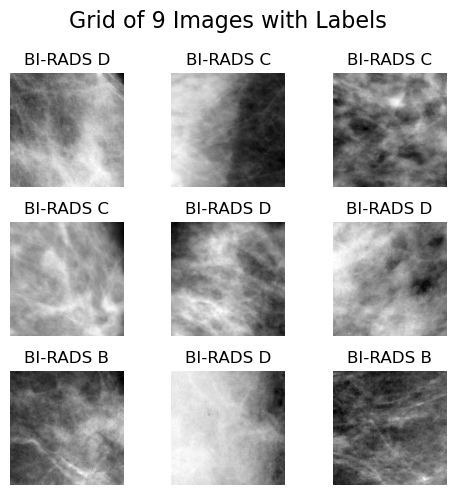

In [9]:
from src.utils.visualization import sample_images

sample_images(dataloaders['train'], label_mapper=IrmaDataset.get_class_label)

# Arquiteturas

## Lucca

In [34]:
kwargs, state = torch.load("models/ae_lucca.pt")

ae_lucca = VAE(**kwargs)
ae_lucca.load_state_dict(state)

summary(ae_lucca, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 32]                  --
│    └─Sequential: 2-1                   [32, 96, 30, 30]          --
│    │    └─Conv2d: 3-1                  [32, 128, 124, 124]       3,328
│    │    └─GELU: 3-2                    [32, 128, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 128, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 96, 60, 60]          110,688
│    │    └─GELU: 3-5                    [32, 96, 60, 60]          --
│    │    └─MaxPool2d: 3-6               [32, 96, 30, 30]          --
│    └─Flatten: 2-2                      [32, 86400]               --
│    └─Sequential: 2-3                   [32, 64]                  --
│    │    └─Linear: 3-7                  [32, 768]                 66,355,968
│    │    └─GELU: 3-8                    [32, 768]                 --

In [8]:
ae_lucca = VAE(
    latent_dim=32,
    conv_layers=[(5, 128), (3, 96)],
    conv_pooling=[2, 2],
    linear_input=(96, 30, 30),
    linear_layers=[768, 384, 128, 64],
)
summary(ae_lucca, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 32]                  --
│    └─Sequential: 2-1                   [32, 96, 30, 30]          --
│    │    └─Conv2d: 3-1                  [32, 128, 124, 124]       3,328
│    │    └─GELU: 3-2                    [32, 128, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 128, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 96, 60, 60]          110,688
│    │    └─GELU: 3-5                    [32, 96, 60, 60]          --
│    │    └─MaxPool2d: 3-6               [32, 96, 30, 30]          --
│    └─Flatten: 2-2                      [32, 86400]               --
│    └─Sequential: 2-3                   [32, 64]                  --
│    │    └─Linear: 3-7                  [32, 768]                 66,355,968
│    │    └─GELU: 3-8                    [32, 768]                 --

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(ae_lucca.parameters())
ae_lucca.to(device)

hist = train(ae_lucca, optimizer, dataloaders['train'], dataloaders['val'], 24, kl_reconstruction_loss)
# hist = train(ae, optimizer, dataloader, dataloader, 20)

[epoch: 1] train_loss: 20.5978 train_rec_loss: 20.5241 train_kl_loss: 0.0737 - val_loss: 11.3406 val_rec_loss: 11.2201 val_kl_loss: 0.1205
[epoch: 2] train_loss: 10.0983 train_rec_loss: 9.9880 train_kl_loss: 0.1103 - val_loss: 8.8297 val_rec_loss: 8.7014 val_kl_loss: 0.1283
[epoch: 3] train_loss: 8.2731 train_rec_loss: 8.1666 train_kl_loss: 0.1065 - val_loss: 8.5221 val_rec_loss: 8.4264 val_kl_loss: 0.0957
[epoch: 4] train_loss: 7.7342 train_rec_loss: 7.6359 train_kl_loss: 0.0983 - val_loss: 7.9628 val_rec_loss: 7.8588 val_kl_loss: 0.1040
[epoch: 5] train_loss: 7.4941 train_rec_loss: 7.3979 train_kl_loss: 0.0963 - val_loss: 7.6732 val_rec_loss: 7.5758 val_kl_loss: 0.0975
[epoch: 6] train_loss: 7.1610 train_rec_loss: 7.0673 train_kl_loss: 0.0936 - val_loss: 7.2166 val_rec_loss: 7.1173 val_kl_loss: 0.0993
[epoch: 7] train_loss: 6.7548 train_rec_loss: 6.6596 train_kl_loss: 0.0952 - val_loss: 6.8889 val_rec_loss: 6.7929 val_kl_loss: 0.0961
[epoch: 8] train_loss: 6.3953 train_rec_loss: 6.29

test_loss: 4.7789 test_rec_loss: 4.6724 test_kl_loss: 0.1065


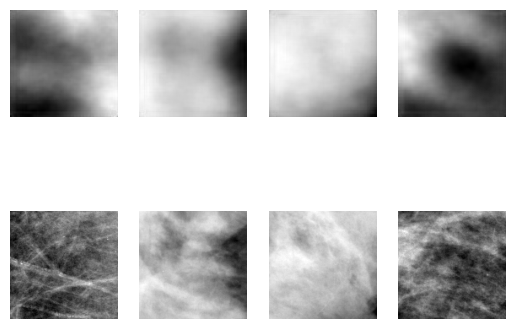

In [20]:
test_metrics = validate(ae_lucca, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(ae_lucca, dataloaders['test'])

In [10]:
torch.save((ae_lucca.kwargs ,ae_lucca.state_dict()), "models/ae_lucca.pt")

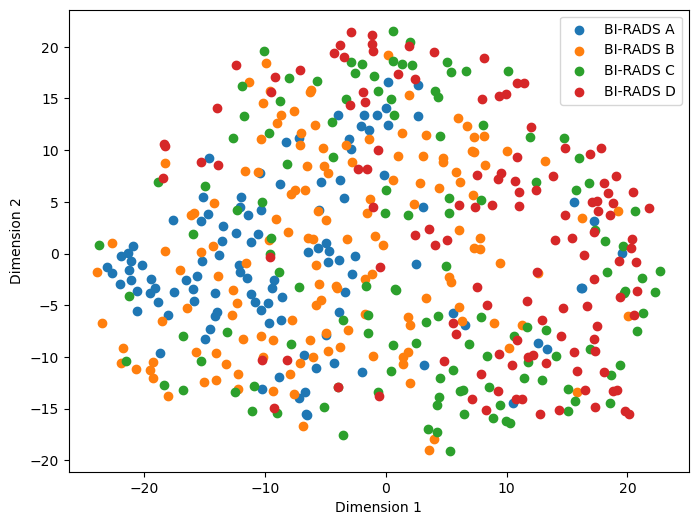

In [35]:
latent, labels = get_latent(ae_lucca, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
tsne_latent = tsne.fit_transform(latent)

plot_2d(tsne_latent, labels, 'tab10')

## 32 Dimensões

In [43]:
ae_leo = VAE(
    latent_dim=32,
    conv_layers=[(5, 64), (3, 128), (3, 256)],
    conv_pooling=[2, 2, 2],
    linear_input=(256, 14, 14),
    linear_layers=[512, 256, 128, 64],
)
summary(ae_leo, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 32]                  --
│    └─Sequential: 2-1                   [32, 256, 14, 14]         --
│    │    └─Conv2d: 3-1                  [32, 64, 124, 124]        1,664
│    │    └─GELU: 3-2                    [32, 64, 124, 124]        --
│    │    └─MaxPool2d: 3-3               [32, 64, 62, 62]          --
│    │    └─Conv2d: 3-4                  [32, 128, 60, 60]         73,856
│    │    └─GELU: 3-5                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 256, 28, 28]         295,168
│    │    └─GELU: 3-8                    [32, 256, 28, 28]         --
│    │    └─MaxPool2d: 3-9               [32, 256, 14, 14]         --
│    └─Flatten: 2-2                      [32, 50176]               --
│  

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(ae_leo.parameters())
ae_leo.to(device)

hist = train(ae_leo, optimizer, dataloaders['train'], dataloaders['val'], 24, kl_reconstruction_loss)
# hist = train(ae, optimizer, dataloader, dataloader, 20)

[epoch: 1] train_loss: 72.5556 train_rec_loss: 72.4725 train_kl_loss: 0.0831 - val_loss: 722.3555 val_rec_loss: 722.3038 val_kl_loss: 0.0517
[epoch: 2] train_loss: 25.5173 train_rec_loss: 25.4784 train_kl_loss: 0.0389 - val_loss: 17.6419 val_rec_loss: 17.5651 val_kl_loss: 0.0768
[epoch: 3] train_loss: 13.3468 train_rec_loss: 13.2366 train_kl_loss: 0.1102 - val_loss: 10.2826 val_rec_loss: 10.1474 val_kl_loss: 0.1353
[epoch: 4] train_loss: 8.8487 train_rec_loss: 8.7032 train_kl_loss: 0.1455 - val_loss: 8.8222 val_rec_loss: 8.6793 val_kl_loss: 0.1429
[epoch: 5] train_loss: 8.3319 train_rec_loss: 8.2031 train_kl_loss: 0.1288 - val_loss: 8.5241 val_rec_loss: 8.4039 val_kl_loss: 0.1203
[epoch: 6] train_loss: 8.2097 train_rec_loss: 8.0944 train_kl_loss: 0.1154 - val_loss: 8.6083 val_rec_loss: 8.4953 val_kl_loss: 0.1130
[epoch: 7] train_loss: 8.0982 train_rec_loss: 7.9889 train_kl_loss: 0.1093 - val_loss: 8.3406 val_rec_loss: 8.2351 val_kl_loss: 0.1055
[epoch: 8] train_loss: 8.0375 train_rec_l

In [50]:
torch.save((ae_leo.kwargs ,ae_leo.state_dict()), "models/ae_leo.pt")

test_loss: 6.0731 test_rec_loss: 5.9663 test_kl_loss: 0.1068


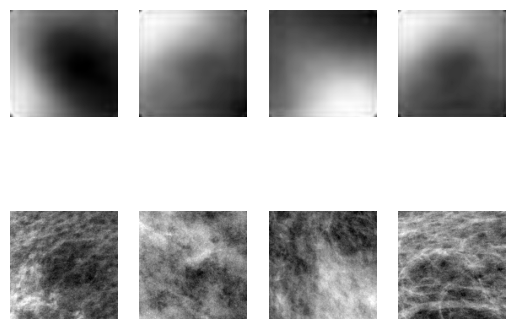

In [46]:
test_metrics = validate(ae_leo, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(ae_leo, dataloaders['test'])

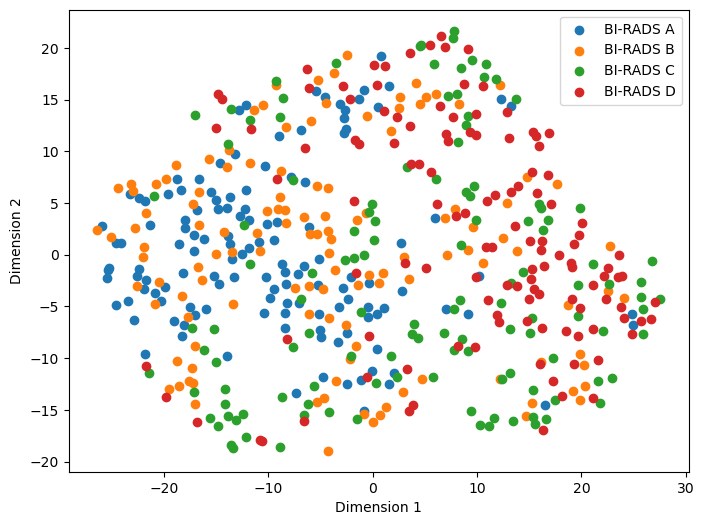

In [52]:
latent, labels = get_latent(ae_leo, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
tsne_latent = tsne.fit_transform(latent)

plot_2d(tsne_latent, labels, 'tab10')

## 64 dims

In [10]:
ae_leo_latent_dim64 = VAE(
    latent_dim=64,
    conv_layers=[(5, 256), (3, 192), (3, 128), (3, 64)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(64, 6, 6),
    linear_layers=[256, 128, 64],
)
summary(ae_leo_latent_dim64, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 64]                  --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 256, 124, 124]       6,656
│    │    └─GELU: 3-2                    [32, 256, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 256, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 192, 60, 60]         442,560
│    │    └─GELU: 3-5                    [32, 192, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 192, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 128, 28, 28]         221,312
│    │    └─GELU: 3-8                    [32, 128, 28, 28]         --
│    │    └─MaxPool2d: 3-9               [32, 128, 14, 14]         --
│    │    └─Conv2d: 3-10                 [32, 64, 12, 12]          73,79

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(ae_leo_latent_dim64.parameters())
ae_leo_latent_dim64.to(device)

hist = train(ae_leo_latent_dim64, optimizer, dataloaders['train'], dataloaders['val'], 32, kl_reconstruction_loss)
# hist = train(ae, optimizer, dataloader, dataloader, 20)

[epoch: 1] train_loss: 24.8747 train_rec_loss: 24.8293 train_kl_loss: 0.0455 - val_loss: 11.4968 val_rec_loss: 11.3910 val_kl_loss: 0.1057
[epoch: 2] train_loss: 9.8255 train_rec_loss: 9.7267 train_kl_loss: 0.0987 - val_loss: 8.8673 val_rec_loss: 8.7821 val_kl_loss: 0.0852
[epoch: 3] train_loss: 8.0303 train_rec_loss: 7.9357 train_kl_loss: 0.0946 - val_loss: 7.2551 val_rec_loss: 7.1679 val_kl_loss: 0.0872
[epoch: 4] train_loss: 6.8296 train_rec_loss: 6.7360 train_kl_loss: 0.0937 - val_loss: 6.4768 val_rec_loss: 6.3780 val_kl_loss: 0.0988
[epoch: 5] train_loss: 6.3387 train_rec_loss: 6.2489 train_kl_loss: 0.0898 - val_loss: 6.2212 val_rec_loss: 6.1346 val_kl_loss: 0.0866
[epoch: 6] train_loss: 6.0260 train_rec_loss: 5.9368 train_kl_loss: 0.0892 - val_loss: 5.9389 val_rec_loss: 5.8476 val_kl_loss: 0.0913
[epoch: 7] train_loss: 5.7096 train_rec_loss: 5.6219 train_kl_loss: 0.0877 - val_loss: 5.6370 val_rec_loss: 5.5544 val_kl_loss: 0.0826
[epoch: 8] train_loss: 5.5175 train_rec_loss: 5.430

In [12]:
torch.save((ae_leo_latent_dim64.kwargs ,ae_leo_latent_dim64.state_dict()), "models/ae_leo_64.pt")

test_loss: 4.2072 test_rec_loss: 4.1181 test_kl_loss: 0.0891


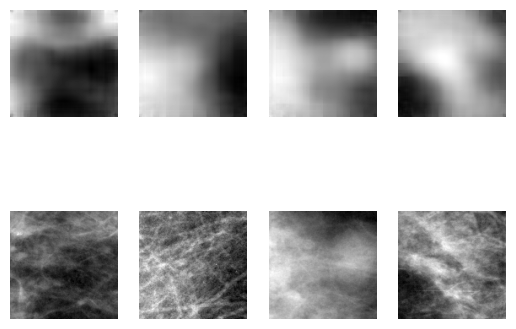

In [13]:
test_metrics = validate(ae_leo_latent_dim64, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(ae_leo_latent_dim64, dataloaders['test'])

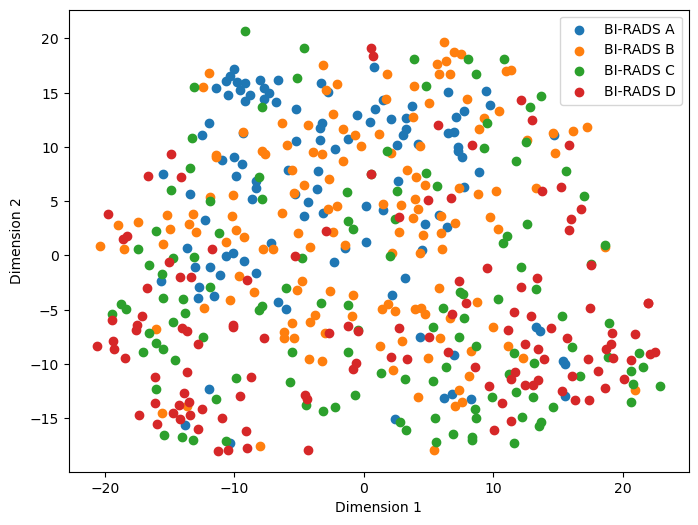

In [14]:
latent, labels = get_latent(ae_leo_latent_dim64, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
tsne_latent = tsne.fit_transform(latent)

plot_2d(tsne_latent, labels, 'tab10')

## 128 dims (pequeno)

In [18]:
ae_leo_128 = VAE(
    latent_dim=128,
    conv_layers=[(5, 64), (3, 128), (3, 256)],
    conv_pooling=[2, 2, 2],
    linear_input=(256, 14, 14),
    linear_layers=[512, 256, 128, 64],
)
summary(ae_leo_128, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 128]                 --
│    └─Sequential: 2-1                   [32, 256, 14, 14]         --
│    │    └─Conv2d: 3-1                  [32, 64, 124, 124]        1,664
│    │    └─GELU: 3-2                    [32, 64, 124, 124]        --
│    │    └─MaxPool2d: 3-3               [32, 64, 62, 62]          --
│    │    └─Conv2d: 3-4                  [32, 128, 60, 60]         73,856
│    │    └─GELU: 3-5                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 256, 28, 28]         295,168
│    │    └─GELU: 3-8                    [32, 256, 28, 28]         --
│    │    └─MaxPool2d: 3-9               [32, 256, 14, 14]         --
│    └─Flatten: 2-2                      [32, 50176]               --
│  

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(ae_leo_128.parameters())
ae_leo_128.to(device)

hist = train(ae_leo_128, optimizer, dataloaders['train'], dataloaders['val'], 32, kl_reconstruction_loss)
# hist = train(ae, optimizer, dataloader, dataloader, 20)

[epoch: 1] train_loss: 33.5552 train_rec_loss: 33.5428 train_kl_loss: 0.0123 - val_loss: 22.0035 val_rec_loss: 21.9977 val_kl_loss: 0.0058
[epoch: 2] train_loss: 17.0515 train_rec_loss: 17.0219 train_kl_loss: 0.0296 - val_loss: 13.5179 val_rec_loss: 13.4703 val_kl_loss: 0.0476
[epoch: 3] train_loss: 11.6829 train_rec_loss: 11.6290 train_kl_loss: 0.0539 - val_loss: 11.0988 val_rec_loss: 11.0395 val_kl_loss: 0.0594
[epoch: 4] train_loss: 9.3532 train_rec_loss: 9.2748 train_kl_loss: 0.0784 - val_loss: 9.1713 val_rec_loss: 9.0904 val_kl_loss: 0.0809
[epoch: 5] train_loss: 8.3701 train_rec_loss: 8.2918 train_kl_loss: 0.0783 - val_loss: 8.3816 val_rec_loss: 8.3081 val_kl_loss: 0.0735
[epoch: 6] train_loss: 80.7878 train_rec_loss: 80.7363 train_kl_loss: 0.0515 - val_loss: 57.5007 val_rec_loss: 57.4885 val_kl_loss: 0.0122
[epoch: 7] train_loss: 23.3319 train_rec_loss: 23.1843 train_kl_loss: 0.1476 - val_loss: 14.0155 val_rec_loss: 13.8275 val_kl_loss: 0.1879
[epoch: 8] train_loss: 12.9831 trai

In [20]:
torch.save((ae_leo_128.kwargs, ae_leo_128.state_dict()), "models/ae_leo_128.pt")

test_loss: 6.4110 test_rec_loss: 6.2880 test_kl_loss: 0.1230


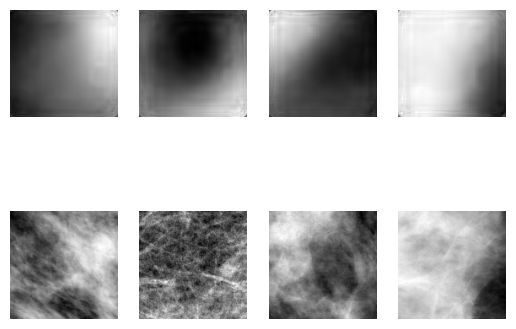

In [ ]:
test_metrics = validate(ae_leo_128, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(ae_leo_128, dataloaders['test'])

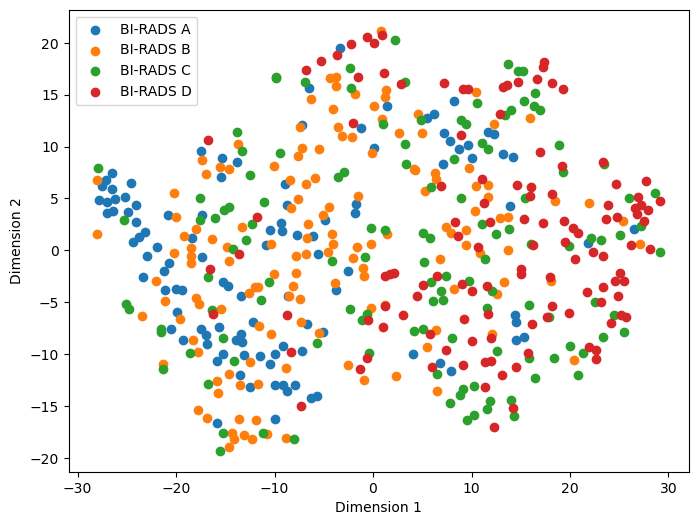

In [22]:
latent, labels = get_latent(ae_leo_128, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
tsne_latent = tsne.fit_transform(latent)

plot_2d(tsne_latent, labels, 'tab10')

## 128 dims (grande)

In [28]:
ae_leo_128_big = VAE(
    latent_dim=128,
    conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
    conv_pooling=[2, 2, 2, 2],
    linear_input=(64, 6, 6),
    linear_layers=[256, 128, 64],
)
summary(ae_leo_128_big, input_size=(32, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [32, 1, 128, 128]         --
├─Encoder: 1-1                           [32, 128]                 --
│    └─Sequential: 2-1                   [32, 64, 6, 6]            --
│    │    └─Conv2d: 3-1                  [32, 192, 124, 124]       4,992
│    │    └─GELU: 3-2                    [32, 192, 124, 124]       --
│    │    └─MaxPool2d: 3-3               [32, 192, 62, 62]         --
│    │    └─Conv2d: 3-4                  [32, 128, 60, 60]         221,312
│    │    └─GELU: 3-5                    [32, 128, 60, 60]         --
│    │    └─MaxPool2d: 3-6               [32, 128, 30, 30]         --
│    │    └─Conv2d: 3-7                  [32, 96, 28, 28]          110,688
│    │    └─GELU: 3-8                    [32, 96, 28, 28]          --
│    │    └─MaxPool2d: 3-9               [32, 96, 14, 14]          --
│    │    └─Conv2d: 3-10                 [32, 64, 12, 12]          55,36

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(ae_leo_128_big.parameters())
ae_leo_128_big.to(device)

hist = train(ae_leo_128_big, optimizer, dataloaders['train'], dataloaders['val'], 24, kl_reconstruction_loss)
# hist = train(ae, optimizer, dataloader, dataloader, 20)

[epoch: 1] train_loss: 25.0981 train_rec_loss: 25.0812 train_kl_loss: 0.0169 - val_loss: 15.8291 val_rec_loss: 15.7885 val_kl_loss: 0.0406
[epoch: 2] train_loss: 11.4011 train_rec_loss: 11.3225 train_kl_loss: 0.0786 - val_loss: 9.2679 val_rec_loss: 9.1699 val_kl_loss: 0.0980
[epoch: 3] train_loss: 8.7658 train_rec_loss: 8.6877 train_kl_loss: 0.0781 - val_loss: 8.6765 val_rec_loss: 8.6113 val_kl_loss: 0.0652
[epoch: 4] train_loss: 8.5111 train_rec_loss: 8.4422 train_kl_loss: 0.0689 - val_loss: 8.0365 val_rec_loss: 7.9565 val_kl_loss: 0.0800
[epoch: 5] train_loss: 7.3103 train_rec_loss: 7.2293 train_kl_loss: 0.0810 - val_loss: 7.1445 val_rec_loss: 7.0656 val_kl_loss: 0.0789
[epoch: 6] train_loss: 6.4587 train_rec_loss: 6.3797 train_kl_loss: 0.0790 - val_loss: 6.2745 val_rec_loss: 6.1998 val_kl_loss: 0.0747
[epoch: 7] train_loss: 6.1948 train_rec_loss: 6.1169 train_kl_loss: 0.0779 - val_loss: 6.0763 val_rec_loss: 5.9937 val_kl_loss: 0.0827
[epoch: 8] train_loss: 5.9894 train_rec_loss: 5.9

In [30]:
torch.save((ae_leo_128_big.kwargs, ae_leo_128_big.state_dict()), "models/ae_leo_128_big.pt")

test_loss: 4.5230 test_rec_loss: 4.4412 test_kl_loss: 0.0817


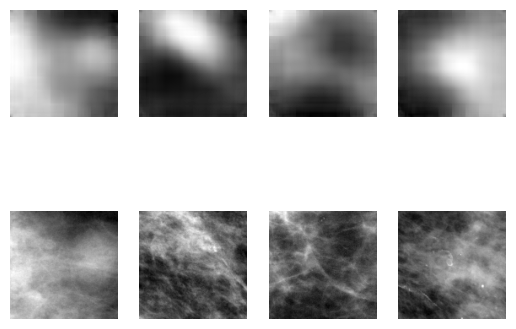

In [31]:
test_metrics = validate(ae_leo_128_big, dataloaders['test'], kl_reconstruction_loss)

print(get_metrics_str(test_metrics, 'test_'))

plot_reconstructions(ae_leo_128_big, dataloaders['test'])

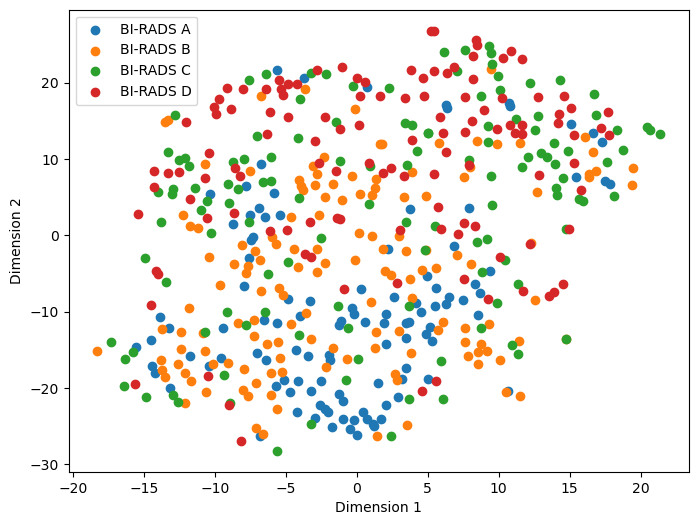

In [32]:
latent, labels = get_latent(ae_leo_128_big, dataloaders["test"], IrmaDataset.get_class_label)

tsne = TSNE()
tsne_latent = tsne.fit_transform(latent)

plot_2d(tsne_latent, labels, 'tab10')